### Load Packages

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
#tk_user_enga = pd.read_csv("takehome_user_engagement.csv",parse_dates=True,index_col='time_stamp')

Load "takehome_user_engagement.csv" file

In [2]:
tk_user_enga = pd.read_csv("takehome_user_engagement.csv", parse_dates = ['time_stamp'], infer_datetime_format=True)
tk_user_enga.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


### Define "Adopted" User

In [3]:
sub_tk = tk_user_enga.groupby(['user_id']).count()>=3
sub_tk_ind = sub_tk.index[sub_tk['visited']]
tk_user_enga2 = tk_user_enga.loc[tk_user_enga['user_id'].isin(sub_tk_ind)]
#tk_user_enga2 = tk_user_enga2.sort_index()
#tk_user_enga2 = tk_user_enga2.sort_values(by=['user_id'])
tk_user_enga2 = tk_user_enga2.sort_values(by=['time_stamp'])
print(tk_user_enga2.head())

                time_stamp  user_id  visited
59486  2012-05-31 15:47:36     3428        1
26821  2012-05-31 21:58:33     1693        1
140780 2012-06-01 20:02:35     8068        1
60374  2012-06-02 00:28:47     3514        1
126542 2012-06-02 06:23:51     7170        1


In [4]:
def if_adopted_user(tk_user_enga2, user_id):
    tk_user_id = tk_user_enga2[tk_user_enga2.user_id==user_id]

    for i in range(0,tk_user_id.shape[0]-2,1):
        start = tk_user_id.time_stamp.iloc[i]
        end = start+datetime.timedelta(days=7)
        tk_user_id_cur =  tk_user_id[tk_user_id.time_stamp>=start]
        tk_user_id_cur = tk_user_id_cur[tk_user_id_cur.time_stamp<=end]
        if tk_user_id_cur.shape[0]>=3:
            return user_id
    return 0

adopted_id = [if_adopted_user(tk_user_enga2,int(item)) for item in tk_user_enga2.user_id.unique()]
adopted_id = [item for item in adopted_id if item!=0]

### Load "takehome_users.csv" file

In [5]:
tk_user = pd.read_csv("takehome_users.csv",encoding='latin-1')
tk_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
tk_user.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

### Remove three columns: name, org_id, invited_by_user_id

In [7]:
print(tk_user['org_id'].value_counts())
print(tk_user['invited_by_user_id'].value_counts())
tk_user.drop(columns=['name','org_id','invited_by_user_id'],inplace=True)

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64
10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
           ..
2746.0      1
10456.0     1
8371.0      1
6266.0      1
3572.0      1
Name: invited_by_user_id, Length: 2564, dtype: int64


### Data Wrangling
### Data Clean and Create Features for tk_user

In [8]:
tk_user['creation_time'] = pd.to_datetime(tk_user['creation_time'], format='%Y-%m-%d %H:%M:%S')
tk_user['last_session_creation_time'] = pd.to_datetime(tk_user['last_session_creation_time'], unit='s')
# calculate user last login spread days, defined as number of days between account creation and last use
tk_user['lst_sp_days'] = tk_user['last_session_creation_time'] - tk_user['creation_time']
tk_user['lst_sp_days'] = tk_user['lst_sp_days'].dt.days
# calculate account age, defined as number of days since account creation and now
# Not sure when this dataset was collected. Let's use the latest date in creation_time
latest = max(tk_user['creation_time'])
tk_user['reg_days'] = latest - tk_user['creation_time']
tk_user['reg_days'] = tk_user['reg_days'].dt.days
tk_user['email_type'] = tk_user['email'].apply(lambda x: x.split("@")[1])
# drop the three original columns
tk_user = tk_user.drop(['creation_time', 'last_session_creation_time', 'email'], axis=1)
tk_user.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,lst_sp_days,reg_days,email_type
0,1,GUEST_INVITE,1,0,0.0,38,yahoo.com
1,2,ORG_INVITE,0,0,136.0,196,gustr.com
2,3,ORG_INVITE,0,0,0.0,437,gustr.com
3,4,GUEST_INVITE,0,0,1.0,374,yahoo.com
4,5,GUEST_INVITE,0,0,5.0,498,yahoo.com


### check email type and keep first 6 most counts

In [9]:
print(tk_user.email_type.value_counts().head(10))
print("total length of dataset:{}".format(len(tk_user)))
print("total counts of first 6 email type:{}".format(tk_user.email_type.value_counts().head(6).sum()))

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
xybhi.com            2
rerwl.com            2
qgjbc.com            2
xvnbr.com            2
Name: email_type, dtype: int64
total length of dataset:12000
total counts of first 6 email type:10814


In [10]:
keep_email_type = ["gmail.com","yahoo.com", "jourrapide.com", "cuvox.de","gustr.com","hotmail.com"]
tk_user.email_type = tk_user.email_type.apply(lambda x: x if x in keep_email_type else "others")
tk_user.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,lst_sp_days,reg_days,email_type
0,1,GUEST_INVITE,1,0,0.0,38,yahoo.com
1,2,ORG_INVITE,0,0,136.0,196,gustr.com
2,3,ORG_INVITE,0,0,0.0,437,gustr.com
3,4,GUEST_INVITE,0,0,1.0,374,yahoo.com
4,5,GUEST_INVITE,0,0,5.0,498,yahoo.com


### Merge with adopted_id

In [11]:
adopted_df = pd.DataFrame(adopted_id,columns=['adopted_id'])
adopted_df['adopted']=1
#print(adopted_df.head())
tk_user = tk_user.merge(adopted_df, how = 'left', left_on = 'object_id', right_on = 'adopted_id')
tk_user.adopted.fillna(0,inplace=True)
tk_user.drop(columns = ['adopted_id'], inplace=True)
#tk_user2.adopted.apply(lambda x: 1 if x!=0 else 0)
tk_user.head()
#tk_user.groupby(['adopted']).describe()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,lst_sp_days,reg_days,email_type,adopted
0,1,GUEST_INVITE,1,0,0.0,38,yahoo.com,0.0
1,2,ORG_INVITE,0,0,136.0,196,gustr.com,1.0
2,3,ORG_INVITE,0,0,0.0,437,gustr.com,0.0
3,4,GUEST_INVITE,0,0,1.0,374,yahoo.com,0.0
4,5,GUEST_INVITE,0,0,5.0,498,yahoo.com,0.0


In [12]:
tk_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
object_id                     12000 non-null int64
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
lst_sp_days                   8823 non-null float64
reg_days                      12000 non-null int64
email_type                    12000 non-null object
adopted                       12000 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 843.8+ KB


### There are 8823 lst_sp_days non-missing, replace missing by 0 (assume their last session time is their account created time)

In [13]:
tk_user.lst_sp_days.fillna(0,inplace=True)
tk_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 8 columns):
object_id                     12000 non-null int64
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
lst_sp_days                   12000 non-null float64
reg_days                      12000 non-null int64
email_type                    12000 non-null object
adopted                       12000 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 843.8+ KB


In [14]:
tk_user = tk_user.set_index('object_id')
tk_user.index.name = 'user_id'
tk_user.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,lst_sp_days,reg_days,email_type,adopted
user_id,,,,,,,
1,GUEST_INVITE,1,0,0.0,38,yahoo.com,0.0
2,ORG_INVITE,0,0,136.0,196,gustr.com,1.0
3,ORG_INVITE,0,0,0.0,437,gustr.com,0.0
4,GUEST_INVITE,0,0,1.0,374,yahoo.com,0.0
5,GUEST_INVITE,0,0,5.0,498,yahoo.com,0.0


### EDA

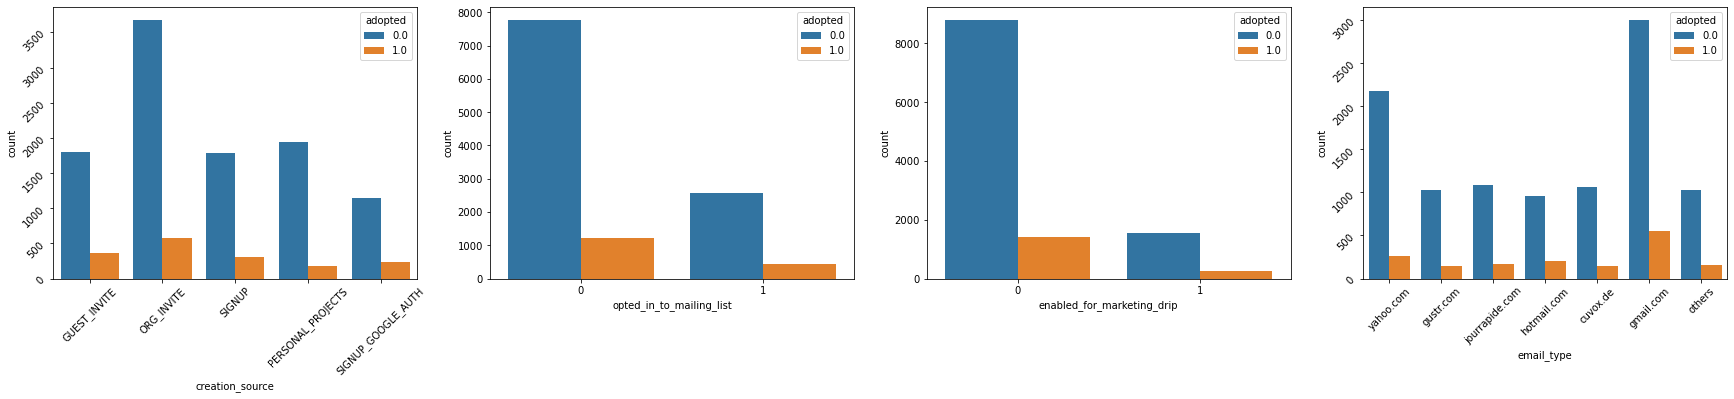

In [15]:
fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(141)
ax1 = sns.countplot(x='creation_source', data=tk_user, hue='adopted')
ax1.tick_params(labelrotation=45)
ax2 = fig.add_subplot(142)
ax2 = sns.countplot(x='opted_in_to_mailing_list', data=tk_user, hue='adopted')
ax3 = fig.add_subplot(143)
ax3 = sns.countplot(x='enabled_for_marketing_drip', data=tk_user, hue='adopted')
ax4 = fig.add_subplot(144)
ax4 = sns.countplot(x='email_type', data=tk_user, hue='adopted')
#ax2.set_xticklabels(labels = 'opted_in_to_mailing_list',rotation=90)
ax4.tick_params(labelrotation=45)
plt.show()

### Check Difference for creation_source, opted_in_to_mailing_list, enabled_for_marketing_drip and email_type, respectively. Do Chi square test

In [16]:
from scipy.stats import chi2_contingency
crosstab = pd.crosstab(tk_user['creation_source'], tk_user['adopted'])
results = chi2_contingency(crosstab)
print('creation_source,chi2 = {}\tp = {}'.format(results[0], results[1]))

crosstab = pd.crosstab(tk_user['opted_in_to_mailing_list'], tk_user['adopted'])
results = chi2_contingency(crosstab)
print('opted_in_to_mailing_list, chi2 = {}\tp = {}'.format(results[0], results[1]))

crosstab = pd.crosstab(tk_user['enabled_for_marketing_drip'], tk_user['adopted'])
results = chi2_contingency(crosstab)
print('enabled_for_marketing_drip, chi2 = {}\tp = {}'.format(results[0], results[1]))

crosstab = pd.crosstab(tk_user['email_type'], tk_user['adopted'])
results = chi2_contingency(crosstab)
print('email_type, chi2 = {}\tp = {}'.format(results[0], results[1]))

creation_source,chi2 = 91.04842041636412	p = 7.884346873316259e-19
opted_in_to_mailing_list, chi2 = 0.8789863657841395	p = 0.34847945597884034
enabled_for_marketing_drip, chi2 = 0.46716408473039095	p = 0.49429472330968593
email_type, chi2 = 45.98325802789899	p = 2.9833604164286256e-08


In [17]:
# Chi square significant for creation_source, email_type
print(tk_user.groupby('creation_source')['adopted'].apply(lambda x: sum(x)/len(x)),"\n")
print(tk_user.groupby('email_type')['adopted'].apply(lambda x: sum(x)/len(x)),"\n")

print(tk_user.groupby('opted_in_to_mailing_list')['adopted'].apply(lambda x: sum(x)/len(x)),"\n")
print(tk_user.groupby('enabled_for_marketing_drip')['adopted'].apply(lambda x: sum(x)/len(x)))

creation_source
GUEST_INVITE          0.170596
ORG_INVITE            0.134932
PERSONAL_PROJECTS     0.081478
SIGNUP                0.144705
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted, dtype: float64 

email_type
cuvox.de          0.119800
gmail.com         0.156373
gustr.com         0.127226
hotmail.com       0.175966
jourrapide.com    0.135028
others            0.137437
yahoo.com         0.109113
Name: adopted, dtype: float64 

opted_in_to_mailing_list
0    0.136243
1    0.143287
Name: adopted, dtype: float64 

enabled_for_marketing_drip
0    0.137049
1    0.143415
Name: adopted, dtype: float64


Higher adopted user in GUEST_INVITE and SIGNUP_GOOGLE_AUTH; higher adopted user in gmail and hotmail. That can be understood since guest invited user, goole user and hotmail user are more engaged.

In [18]:
from statsmodels.stats.weightstats import CompareMeans

def z_test(df, col, target='adopted'):
    opted_in = df.loc[tk_user[col]==1, target]
    opted_out = df.loc[tk_user[col]==0, target]
    z_data = CompareMeans.from_data(opted_in, opted_out)
    z, p = CompareMeans.ztest_ind(z_data)
    print('For {}, z = {}, p = {}'.format(col, z, p))
z_test(tk_user, 'opted_in_to_mailing_list')
z_test(tk_user,'enabled_for_marketing_drip')

For opted_in_to_mailing_list, z = 0.9680825369364737, p = 0.3330031505646689
For enabled_for_marketing_drip, z = 0.7205798349185616, p = 0.471168064268643


No Mean difference between opted_in_to_mailing_list and endabled_for_marketing_drip

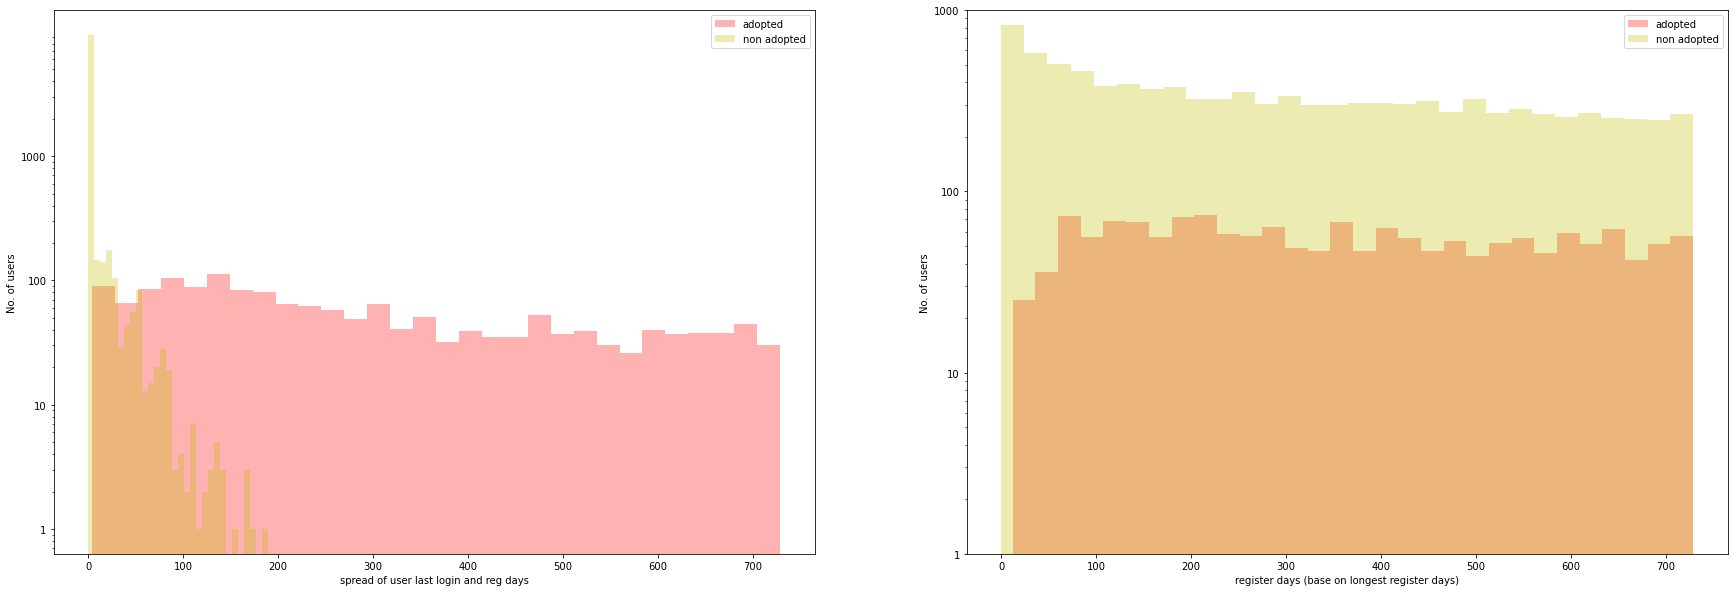

In [19]:
# history and adopted user
def plot_hist_days(df, col, xlabel):
    _ = plt.hist(df.loc[tk_user['adopted']==1, col], 
                 bins=30, alpha=0.3, color='r', label='adopted')
    _ = plt.hist(df.loc[tk_user['adopted']==0, col], 
                 bins=30, alpha=0.3, color='y', label='non adopted')
    _ = plt.yscale('log')
    _ = plt.legend()
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel('No. of users')
    _ = plt.yticks([1, 10, 100, 1000], ['1', '10', '100', '1000'])

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)
ax1 = plot_hist_days(tk_user, 'lst_sp_days', 'spread of user last login and reg days')
ax2 = fig.add_subplot(122)
ax2 = plot_hist_days(tk_user, 'reg_days', 'register days (base on longest register days)')

users with long history are more likely to be adopted users; the adoption rate is lower in very new accounts and stable in all time period.

### Modeling

In [20]:
### create dummy variables for creation_source and email_type
creation_source = pd.get_dummies(tk_user['creation_source'], drop_first=True)
tk_user2= pd.concat([tk_user, creation_source], axis=1).drop('creation_source', axis=1)

email_type = pd.get_dummies(tk_user['email_type'], drop_first=True)
tk_user2= pd.concat([tk_user2, email_type], axis=1).drop('email_type', axis=1)

In [21]:
### create target variable and split data
y = tk_user2['adopted']
X = tk_user2.drop('adopted', axis=1)
# though account_age and history have different scales than other features,
# I plan to use random forest model, which is not affectd by the different scales
# no need to scale the data
# create training and testing sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use 5 folder stratified CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200, 300]}
model = GridSearchCV(clf, params, cv=5)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 200}
Best average precision was 0.9723333333333333


In [23]:
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=200
)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Accuracy of test set was', accuracy_score(ytest, ypred))
print(classification_report(ytest, ypred))

Accuracy of test set was 0.9656666666666667
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      2586
         1.0       0.89      0.85      0.87       414

    accuracy                           0.97      3000
   macro avg       0.94      0.92      0.93      3000
weighted avg       0.97      0.97      0.97      3000



lst_sp_days                   88.802840
reg_days                       7.500915
PERSONAL_PROJECTS              0.785765
opted_in_to_mailing_list       0.388290
enabled_for_marketing_drip     0.348763
ORG_INVITE                     0.344928
gmail.com                      0.331420
SIGNUP                         0.271014
hotmail.com                    0.251732
yahoo.com                      0.251483
jourrapide.com                 0.211120
SIGNUP_GOOGLE_AUTH             0.176978
others                         0.170945
gustr.com                      0.163806
dtype: float64


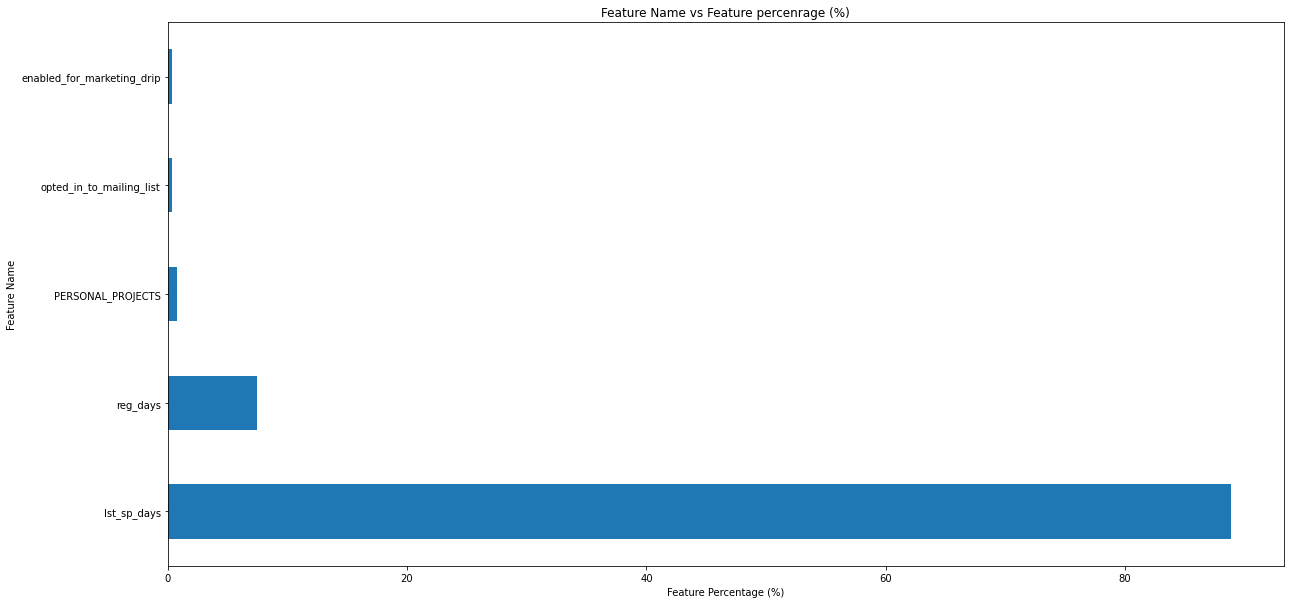

In [24]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp = 100*feat_imp.sort_values(ascending=False)
print(feat_imp)
fig = plt.figure(figsize=(20,10))
_ = feat_imp.nlargest(5).plot(kind='barh')
_ = plt.xlabel('Feature Percentage (%)')
_ = plt.ylabel('Feature Name')
_ = plt.title('Feature Name vs Feature percenrage (%)')

### Conclusion

Most important feature is spread of user last login and reg days, then register days and creation souce with PERSONAL_PROJECTS are relative important.
To increase adopted id:
- Encourage users to login frequently
- Let more users who do personal project to create account
- Encourage more users to choose to receive marketing emails